In [1]:
using Iterators
using DataStructures
using Pipe
using Compat

macro printval(ee)
    ee_expr = @sprintf "%s" string(ee)
    esc(:(println($ee_expr," = ", $ee)))
end

macro pz(ee)
    ee_expr = @sprintf "%s" string(ee)
    esc(:(println($ee_expr,"\t\t",typeof($ee), "\t", size($ee))))
end

push!(LOAD_PATH, ".")
push!(LOAD_PATH, "../util")


4-element Array{ByteString,1}:
 "/home/ubuntu/build/julia-master/usr/local/share/julia/site/v0.5"
 "/home/ubuntu/build/julia-master/usr/share/julia/site/v0.5"      
 "."                                                              
 "../util"                                                        

In [2]:
using Packing
using Optim
push!(LOAD_PATH, "../Optimisation")
using AdaDelta

In [3]:
function clean(ss)
    @pipe (ss 
    |> replace(_, r"\[.*?\] ?","")  #Remove Nonword sounds
    |> replace(_, r"\<.*?\> ","")  #Remove Verbal Deltions
    |> replace(_, r"\*(.*?)\*",s"\1") #Remove mispronounciation marks
    |> replace(_,r"\:|\-\s\.\s\-", "") #remove intraword pauses
    |> replace(_,r"\w+\- ","") #remove stuttered words
    |> replace(_, r"[!\.,\?]","")        #Remove punctation as it is not used traditionally (see sro spec)
    
    |> replace(_, r"\s+",' ') #Remove repeated spaces
    #|> replace(_, r"([A-Z])\s([A-Z])", s"\1\2") #Merge len(2) abbrev
    |> replace(_, r".*[~\(\)\-\<\>#'].*","")#Remove everything if anything unfixable found
    |> lowercase
    |> strip 
    )
end


clean (generic function with 1 method)

In [4]:
const START_MARKER = "**START**"
const END_MARKER = "**END**"

"**END**"

In [50]:
path="../../Resources/corpora/atis2_text/"
function valid(ss)
    typeof(ss) <: ASCIIString && length(ss)>0
end
    
corpus = @pipe readdir(path)  |> filter!(fn -> splitext(fn)[2]==".sro", _) |> map(_) do fn
    try open(readall, path*fn) end
    end |> filter!(valid,_) |> map(clean,_) |> filter!(valid,_) |> map(s->split(s),_) |> filter(ss->length(ss)>1, _);
corpus_vocab = @pipe corpus |> map(Set,_) |> reduce(union,_)
length(corpus_vocab)

1127

In [51]:
using WordEmbeddings
LL, word_indexes, indexed_words = load_word2vec_embeddings("word_emb_data/GoogleNews-vectors-negative300.bin", length(corpus_vocab), corpus_vocab);

In [52]:
setdiff(corpus_vocab,indexed_words)


15-element Array{UTF8String,1}:
 "and"      
 "a"        
 "nondirect"
 "maluso"   
 "of"       
 "panam"    
 "stapleton"
 "fokker"   
 "lufthansa"
 "to"       
 "laguardia"
 "nonjets"  
 "hartfield"
 "mcdonnell"
 "dulles"   

In [53]:
#Kind of the opposite of a stop word. This word has little meaning (So zero value), but much structural importance
forcewords = ["and", "a", "of", "to"]
for word in forcewords
    @assert(!(word in indexed_words))
    push!(indexed_words, word)
    word_indexes[word] = length(indexed_words)
end
LL = [LL zeros(size(LL,1),length(forcewords))]

300x1116 Array{Float64,2}:
  0.0529562  -0.00851202  -0.0123606    …  -0.0548293   0.0  0.0  0.0  0.0
  0.0654598  -0.0342245   -0.0222299        0.0239878   0.0  0.0  0.0  0.0
  0.0661953   0.0322839    0.0655398       -0.0190492   0.0  0.0  0.0  0.0
  0.0470722   0.0458679    0.0394772        0.0826471   0.0  0.0  0.0  0.0
  0.0522207  -0.0131429   -0.0866199        0.0620861   0.0  0.0  0.0  0.0
 -0.0820086  -0.0462207    0.0249128    …   0.0465646   0.0  0.0  0.0  0.0
 -0.0614145  -0.00094823  -0.0111628       -0.0786156   0.0  0.0  0.0  0.0
 -0.11621    -0.0522188   -0.0705224       -0.0516041   0.0  0.0  0.0  0.0
  0.0156294   0.0465735    0.092369         0.00902063  0.0  0.0  0.0  0.0
  0.0992929   0.0624509    0.0927522        0.0364857   0.0  0.0  0.0  0.0
 -0.0856861  -0.122785    -0.0563412    …   0.0395094   0.0  0.0  0.0  0.0
 -0.028133   -0.0287556   -0.0605572       -0.0588609   0.0  0.0  0.0  0.0
  0.0522207   0.0515131   -0.0540416       -0.0903071   0.0  0.0  0.0  0.

In [54]:
@assert(!(START_MARKER in indexed_words))
push!(indexed_words, START_MARKER)
word_indexes[START_MARKER] = length(indexed_words)

@assert(!(END_MARKER in indexed_words))
push!(indexed_words, END_MARKER)
word_indexes[END_MARKER] = length(indexed_words)
LL = [LL zeros(size(LL,1),2)]

300x1118 Array{Float64,2}:
  0.0529562  -0.00851202  -0.0123606    …  0.0  0.0  0.0  0.0  0.0  0.0
  0.0654598  -0.0342245   -0.0222299       0.0  0.0  0.0  0.0  0.0  0.0
  0.0661953   0.0322839    0.0655398       0.0  0.0  0.0  0.0  0.0  0.0
  0.0470722   0.0458679    0.0394772       0.0  0.0  0.0  0.0  0.0  0.0
  0.0522207  -0.0131429   -0.0866199       0.0  0.0  0.0  0.0  0.0  0.0
 -0.0820086  -0.0462207    0.0249128    …  0.0  0.0  0.0  0.0  0.0  0.0
 -0.0614145  -0.00094823  -0.0111628       0.0  0.0  0.0  0.0  0.0  0.0
 -0.11621    -0.0522188   -0.0705224       0.0  0.0  0.0  0.0  0.0  0.0
  0.0156294   0.0465735    0.092369        0.0  0.0  0.0  0.0  0.0  0.0
  0.0992929   0.0624509    0.0927522       0.0  0.0  0.0  0.0  0.0  0.0
 -0.0856861  -0.122785    -0.0563412    …  0.0  0.0  0.0  0.0  0.0  0.0
 -0.028133   -0.0287556   -0.0605572       0.0  0.0  0.0  0.0  0.0  0.0
  0.0522207   0.0515131   -0.0540416       0.0  0.0  0.0  0.0  0.0  0.0
  ⋮                                  

In [55]:
known_vocab = Set(indexed_words)
known_corpus = filter(corpus) do sent
    for word in sent
        if !( word in known_vocab)
            return false
        end
    end
    true
end;

In [56]:
################LOADING Done, Now processing

In [57]:
using DataStructures

function Base.sum(acc::Accumulator)
    sum(values(acc.map))
end

function Base.sum(acc::Dict)
    sum(values(acc))
end

function freq2prob{T,V<:Number}(acc::Union{Accumulator{T,V},Dict{T,V}})
    
    ret=Dict{T,Float64}()
    total = sum(acc)
    for (k,v) in acc
        ret[k]=v/total
    end
    ret
end

function dict2mat(bigrams::Dict, word_indexes::Dict{AbstractString,Int64}, dense=False)
    mat  = (dense ? zeros: spzeros)(length(word_indexes),length(word_indexes))
    for first in keys(bigrams)
        for second in keys(bigrams[first])
            mat[word_indexes[second], word_indexes[first]] = bigrams[first][second]
        end
    end
    mat
end


dict2mat (generic function with 2 methods)

In [58]:
function collect_cooccur_stats(sentences)
    unioccur = counter(AbstractString)
    bioccur = DefaultDict(()->counter(AbstractString))
    
    for sent in sentences
        for ii in 1:length(sent)
            push!(unioccur, sent[ii])
            for jj in 1:length(sent)
                if ii==jj
                    continue
                end
                push!(bioccur[sent[ii]], sent[jj])    
            end
        end       
    end
    
    [k=>v.map for (k,v) in bioccur], unioccur.map
    
end

bioccur_freq, unioccur_freq = collect_cooccur_stats(known_corpus)

bioccur_mat = dict2mat(bioccur_freq,word_indexes,true)
bioccur_mat.+=1.0 # Add one smoothing
bioccur_mat./=sum(bioccur_mat)

unioccur = freq2prob(unioccur_freq)
unioccur_vec = Float64[haskey(unioccur,word) ? unioccur[word] : 0.0 for word in indexed_words]

unioccur_vec_smoothed = Float64[word in keys(unioccur_freq) ? unioccur_freq[word] : 0.0 for word in indexed_words]
unioccur_vec_smoothed.+=1.0 # Add one smoothing
unioccur_vec_smoothed./=sum(unioccur_vec_smoothed)

1118-element Array{Float64,1}:
 0.0122218  
 0.00816327 
 0.00760108 
 0.0190374  
 0.026469   
 0.00253369 
 3.08048e-5 
 0.000100116
 0.0413477  
 0.0032499  
 0.000231036
 0.000431267
 0.00122449 
 ⋮          
 3.8506e-5  
 6.16095e-5 
 5.39084e-5 
 0.000169426
 1.54024e-5 
 0.0138621  
 0.011236   
 0.0190913  
 0.0120062  
 0.050181   
 7.70119e-6 
 7.70119e-6 

In [59]:
using Gadfly
using Distributions

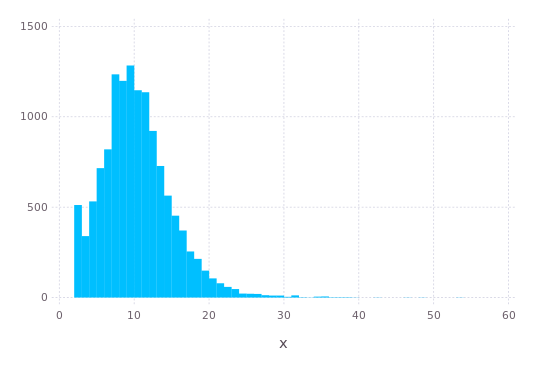

In [60]:
sent_lengths = map(length, known_corpus)
plot(x=sent_lengths, Geom.histogram)

In [61]:
mean(sent_lengths)

9.897132313369724

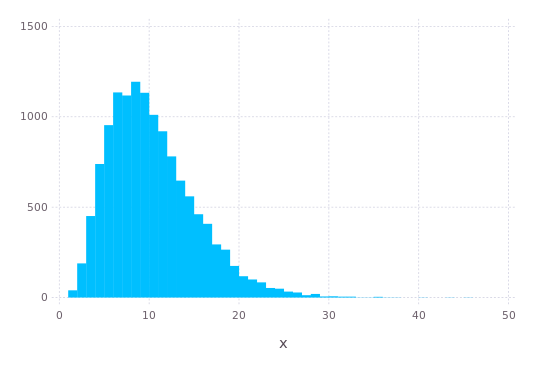

In [62]:
sent_length_dist = fit_mle(Gamma, sent_lengths)
plot(x=[round(rand(sent_length_dist)) for _ in 1:length(sent_lengths)], Geom.histogram)

In [63]:
@printval sent_length_dist.α
@printval sent_length_dist.θ

sent_length_dist.α = 

In [64]:
length_prob=cdf(sent_length_dist,[1.5:1.0:50.5])-cdf(sent_length_dist,[0.5:1.0:49.5])
length_prob./=sum(length_prob)

50-element Array{Float64,1}:
 0.00274146
 0.0142225 
 0.0332953 
 0.0543865 
 0.0725589 
 0.0850581 
 0.0911566 
 0.0914696 
 0.0872774 
 0.0800324 
 0.0710653 
 0.0614481 
 0.0519597 
 ⋮         
 2.85133e-5
 2.02342e-5
 1.43303e-5
 1.01297e-5
 7.14748e-6
 5.03448e-6
 3.54029e-6
 2.48563e-6
 1.74252e-6
 1.2198e-6 
 8.52701e-7
 5.95286e-7

In [65]:
function collect_grams_stats{S}(sentences::Vector{Vector{S}})
    new_unigram = ()->DefaultDict(S,Int,()->0)
    unigrams = new_unigram()
    new_bigram = () -> DefaultDict(S, typeof(unigrams), new_unigram)
    bigrams = new_bigram()
    new_trigram = ()-> DefaultDict(S, typeof(bigrams), new_bigram)
    trigrams = new_trigram()

    for sent in sentences
        bigrams[START_MARKER][sent[1]]+=1
        ii=0
        for ii in 1:length(sent)-2
            unigrams[sent[ii]]+=1
            bigrams[sent[ii]][sent[ii+1]]+=1
            trigrams[sent[ii]][sent[ii+1]][sent[ii+2] ]+=1
            
        end
        unigrams[sent[ii+1]]+=1
        unigrams[sent[ii+2]]+=1
        bigrams[sent[ii+1]][sent[ii+2]]+=1
        bigrams[sent[ii+2]][END_MARKER]+=1
        trigrams[sent[ii+1]][sent[ii+2]][END_MARKER]
    end
    
    
    unigrams = Dict(unigrams)
    function bi2dict(bgs)
        Dict(Pair{S, typeof(unigrams)}[k=>Dict(v) for (k,v) in bgs])
    end
    bigrams = bi2dict(bigrams)
    trigrams = Dict(Pair{S, typeof(bigrams)}[k=>bi2dict(v) for (k,v) in trigrams])
    trigrams, bigrams, unigrams
end




collect_grams_stats (generic function with 1 method)

In [66]:
using StatsBase
# modified from https://github.com/JoFrhwld/GoodTuring.jl/blob/master/GoodTuring.jl
function simpleGoodTuring(speciesCountDict::Dict)
    speciesCountVec = collect(values(speciesCountDict))
        
    totalCounts = sum(speciesCountVec)
    cofcDict = countmap(speciesCountVec)
    r = sort(collect(keys(cofcDict)))

    N = size(r,1)
    Nr = [cofcDict[r[i]] for i in 1:N]

    p0 = haskey(cofcDict, 1.0) ? cofcDict[1.0] / totalCounts : 0.0
    
    Z = sgtZ(r,Nr)
    logr = map(log,r)
    logZ = map(log,Z)

    X = hcat(ones(N), logr)
    Y = copy(logZ )
    coefs = X\Y
    intercept = coefs[1]
    slope = coefs[2]

    useY = false
    rSmooth = Array{Float64}(N)
    for i in 1:N
        @inbounds thisr = r[i]
        
        #y = ((thisr+1.0)^(slope+1.0))/(thisr^slope)
        #The above is the much simplified form of the below (Performance identical output differs by 10^-16)
        y = (thisr+1.0) * exp(slope * log(thisr+1.0) + intercept) / exp(slope * log(thisr) + intercept)

        if !in(thisr+1, r)
            useY = true
        end

        if useY
            rSmooth[i] = y
        else
            x = (thisr+1) * cofcDict[thisr + 1]/cofcDict[thisr]
            thisNr = cofcDict[thisr]
            thisNr1 = cofcDict[thisr+1]

            t = 1.96 * ((thisr+1)^2) * (thisNr1 / thisNr^2) * (1 + (thisNr1 / thisNr))

            if abs(x-y) > t
                @inbounds rSmooth[i] = x
            else
                useY = true
                @inbounds rSmooth[i] = y
            end
        end
    end

    smoothTot = sum(Nr.*rSmooth)
    sgtProb  = (1.0 - p0) .* (rSmooth/smoothTot)
    sgtProbDict = Dict([r[i] => sgtProb[i] for i in 1:N])
    sgtDict = Dict([sp=>sgtProbDict[speciesCountDict[sp]] for sp in keys(speciesCountDict)])

    sgtDict, sgtProbDict, p0
end


function sgtZ(r::Array, Nr::Array)
    j = r
    i = [0; j[1:end-1]]
    lastK = 2*j[end] - i[end]
    k = [j[2:end]; lastK]
    Float64[(2*Nr[iter])/(k[iter]-i[iter]) for iter = 1:length(j)]
end

function simpleGoodTuring(speciesCountVec::Vector)
    sgtD = simpleGoodTuring(Dict([ii=>v for (ii,vv) in enumerate(speciesCountVec)]))
    [sgtD[ii] for ii in 1:length(speciesCountVec)]
end

simpleGoodTuring (generic function with 2 methods)

In [72]:

function katz_bigrams(bigram_freq::Dict, unigram_freq::Dict)
    k_bigrams = Dict()
    
    for first in keys(bigram_freq)
        smoothed,_,p0 = simpleGoodTuring(bigram_freq[first])
        k_bigrams[first] = smoothed
        
        backoff_keys = setdiff(keys(unigram_freq),keys(smoothed))
        #share the p0 proability mass between them
        total = sum([unigrams_freq[key] for key in backoff_keys])
        for second in backoff_keys
            k_bigrams[first][second]=p0.*unigrams_freq[second]./total
        end
    end
    k_bigrams
end

#bigram_freq, unigram_freq = collect_grams_stats(known_corpus);
kbigrams=katz_bigrams(bigrams_freq, unigrams_freq)
kbigrams_mat = dict2mat(kbigrams,word_indexes,true)

1118x1118 Array{Float64,2}:
 0.000739065  0.000845694  0.00104584   …  0.00021674   0.00242428   0.0
 0.000739065  0.00254699   0.000843736     0.000144721  0.000810998  0.0
 0.00293814   0.0166282    0.000650186     0.000106928  0.000428237  0.0
 0.000463166  0.0013176    0.0175479       0.000337682  0.0345652    0.0
 0.000644047  0.00183216   0.00166171      0.000469557  0.00734494   0.0
 6.14806e-5   0.000174898  0.000216289  …  4.48238e-5   0.000200735  0.0
 5.62323e-7   1.59967e-6   1.97825e-6      4.09974e-7   7.46551e-7   0.0
 2.24929e-6   6.39869e-6   0.00166171      1.6399e-6    2.9862e-6    0.0
 0.243678     0.0948053    0.00459815      0.00608653   0.00526891   0.0
 0.00108906   0.000565209  0.000843736     5.7533e-5    0.000504614  0.0
 5.43579e-6   1.54635e-5   1.91231e-5   …  3.96308e-6   0.000126417  0.0
 1.03092e-5   2.93273e-5   3.6268e-5       7.51619e-6   1.36868e-5   0.0
 2.96157e-5   8.42495e-5   0.000104188     2.1592e-5    0.000276128  0.0
 ⋮                     

In [73]:
trigrams_freq, bigrams_freq, unigrams_freq = n_collect_grams_stats(known_corpus)

(Dict("limousines"=>Dict("or"=>Dict("taxi"=>1),"take"=>Dict("me"=>1)),"fight"=>Dict("flights"=>Dict("from"=>1)),"null"=>Dict("on"=>Dict("rental"=>1)),"regular"=>Dict("coach"=>Dict("fare"=>1)),"everywhere"=>Dict("if"=>Dict("you"=>1)),"schedule"=>Dict("available"=>Dict("for"=>1),"of"=>Dict("ground"=>2,"the"=>2,"flights"=>10,"u"=>1,"all"=>4),"again"=>Dict("**END**"=>0),"for"=>Dict("nonstop"=>1,"airlines"=>1,"flight"=>1,"this"=>2,"united"=>1,"the"=>1,"philadelphia"=>1,"flights"=>2,"baltimore"=>1),"flight"=>Dict("eighty"=>1),"me"=>Dict("on"=>1),"from"=>Dict("pittsburgh"=>1,"denver"=>1,"boston"=>8),"a"=>Dict("flight"=>1),"between"=>Dict("boston"=>2),"in"=>Dict("philadelphia"=>2,"san"=>1)),"scone"=>Dict("early"=>Dict("in"=>1)),"during"=>Dict("the"=>Dict("day"=>3,"night"=>1,"flight"=>2,"afternoon"=>1,"week"=>1,"morning"=>4,"weekend"=>1),"weekdays"=>Dict("**END**"=>0),"each"=>Dict("hour"=>1)),"wondering"=>Dict("about"=>Dict("seat"=>1),"what"=>Dict("choices"=>1)),"whose"=>Dict("fares"=>Dict("are

In [ ]:
using MultivariateStats

pcaLL = transform(fit(PCA, LL), LL)


In [ ]:
open("atis_data.jsz","w") do fh
    data = Dict([
        ("bigrams", kbigrams_mat),
        ("bioccur", bioccur_mat),
        ("unioccur", unioccur_vec),
        
        ("length_prob", length_prob),
        ("LL",LL),
        ("pcaLL",pcaLL),
        ("word_indexes", word_indexes),
        ("indexed_words", indexed_words),
        ])
    serialize(fh, data)    
end

In [ ]:
function likelyhood(sent, bigrams)
    words = split(sent)
    words = [START_MARKER; words; END_MARKER]
    
    p=1.0
    for ii in 1:length(words)-1
        p*=bigrams[words[ii]][words[ii+1]]
    end
    p
end


function select_word{S<:AbstractString,V}(unigrams::Dict{S,V})
    cutoff = rand()
    total = 0.0
    for next_word in keys(unigrams)
        total+=unigrams[next_word]
        if total>=cutoff
            return next_word
        end
    end
    assert(False, "Should never reach here") 
end

function random_walk(bigrams)
    words=[]
    cur = START_MARKER
    while(cur!=END_MARKER)
        cur = select_word(bigrams[cur])
        push!(words,cur)
    end
    words = words[1:end-1]
    join(words, " ")
end

walk =random_walk(kbigrams) 
print(walk*"\t")
print(likelyhood(walk,kbigrams))

In [ ]:
LL

Frame's Extra Magic Mass-Sharing Co-occurance PMF, Inspired by Bengio 2003
---

In [ ]:
addprocs(11)

In [ ]:
@everywhere immutable LU_NN{N<:Number}
    C::Matrix{N} #lookup matrix
    H::Matrix{N}
    d::Vector{N}
    U::Matrix{N}
    b::Vector{N}
end

In [ ]:
subset_indexes_for_len = Dict{Int,Vector{Vector{Bool}}}()


function prepare_cases(sentence)
    xs = Int[word_indexes[word] for word in sentence]
    K = length(xs)
    ss ::Vector{Vector{Bool}} = if haskey(subset_indexes_for_len,K)
            subset_indexes_for_len[K]
        else 
            subset_indexes_for_len[K] = Vector{Bool}[collect(pr) for pr in  product([(true,false) for k in 1:K]...)][2:end-1]
        end
    
    CT = Tuple{Vector{Int},Vector{Int}}
    #vcat([CT[(xs[bb],[y]) for y in xs[!bb]] for bb in ss]...)
    CT[(xs[bb],xs[!bb]) for bb in ss]
    
end

In [ ]:
training_cases = @pipe known_corpus |> map(prepare_cases,_) |> vcat(_...)

In [ ]:
function LU_NN(dEmb, dHidden, dOut)
    LU_NN(
        0.01*(randn((dEmb,dOut))), #C
        0.01*(randn((dHidden,dEmb))), #H
        0.01*(randn(dHidden)), #d
        0.01*(randn((dOut,dHidden))), #U
        0.01*(randn(dOut))#b
    )
end

In [ ]:
@everywhere function softmax(xs)
    numer = exp(xs)
    numer./sum(numer)
end


@everywhere function σ(xs)
    1.0./(1+exp(-xs))
end

#########################################



@everywhere function δ(δ_above, W)
    (W'*δ_above)
end

@everywhere function δ_tanh(δ_above, a)
    const dz = 1-a.^2
    δ_above.*dz
end

@everywhere function δ_σ(δ_above, a)
    const dz = a .- a.^2
    δ_above.*dz
end

@everywhere function δ_softmax_ce(actual, expected)
    actual-expected
end

@everywhere function δ_output_sq_loss(actual, expected) 
    -(expected-actual)
end

#############################################

@everywhere function sq_loss(actual, expected)
    0.5*sum((expected-actual).^2)
end

@everywhere function ce_loss(actual, expected)
    @assert(all(actual.>0))
    -sum(expected.*log(actual))
end

@everywhere function forward(x,nn::LU_NN)
    aa = tanh(nn.H*x+nn.d)
    out = softmax(nn.U*aa + nn.b)
    out, aa
end

@everywhere function feedforward_backprop(xx,nn::LU_NN, expected_output)
    actual_output, aa = forward(xx,nn)
    err = ce_loss(actual_output, expected_output)
    #δ_top = δ_tanh(δ_softmax_ce(actual_output, expected_output),actual_output)
    δ_top = δ_softmax_ce(actual_output, expected_output)
    ΔU  = δ_top*aa'
    Δb  = δ_top
    δ_hidden = δ_tanh(δ(δ_top, nn.U),aa)
    ΔH  = δ_hidden*xx'
    Δd  = δ_hidden
    δ_bottom = δ(δ_hidden, nn.H)
    Δx  = δ_bottom
    Δx,ΔH,Δd,ΔU,Δb,err

end

In [ ]:
@everywhere function mysubarray(xs, id=myid(), nchunks=nworkers())
    #THis is broken if workers are not sequentially numbered from 2:nworkers
    len = length(xs)
    chunk_size = div(len, nchunks+1)
    start_index = (id-2)*chunk_size + 1
    end_index = start_index+chunk_size-1
    print(start_index : end_index)
    sub(xs, start_index : end_index)
end

@everywhere function expand_training_case(given_iis, target_iis, nn)
    given_sowe = length(given_iis)>0 ? sum([nn.C[:,g_ii] for g_ii in given_iis]) : zeros(nn.C[:,1])
    target = zeros(nn.b) #just while we are testing use a one hot set rep
    for t_ii in target_iis
        target+=1.0/length(target_iis)
    end
    given_sowe,target
end

@everywhere function train_one(given_iis, target_iis, nn)
    given_sowe,target = expand_training_case(given_iis, target_iis, nn)
        
    Δx,ΔH,Δd,ΔU,Δb,err = feedforward_backprop(given_sowe,nn, target)
    
    ΔC = zeros(nn.C)
    for g_ii in given_iis
        @inbounds ΔC[:, g_ii]+=Δx./length(given_iis)
    end
    ΔC,ΔH,Δd,ΔU,Δb,err
end


function train_all(training_cases,nn)
    
    function accumulate_training_over(cases,fun)
        totals = Any[  
            zeros(nn.C),
            zeros(nn.H),
            zeros(nn.d),
            zeros(nn.U),
            zeros(nn.b),
            0.0]
        for case in cases
            Δs = fun(case)
            for ii in 1:length(totals)
                totals[ii]+=Δs[ii]
            end
        end
        totals
    end
    
    function train_remote()
        accumulate_training_over(mysubarray(training_cases),
                                 gt_iis -> train_one(gt_iis[1], gt_iis[2], nn) )
    end
    
    r_updates = [@spawnat(id, train_remote())  for id in workers()]
        
    totals = accumulate_training_over(r_updates, fetch)
    ([tot./length(training_cases) for tot in totals]...)
end
    

In [ ]:
function uncached_loss_and_loss_grad!(θ::Vector, grad::Vector)    
    unpack!(θ, nn_outer)
    train_results = train_all(training_cases, nn_outer)
    Δs = train_results[1:end-1]
    err = train_results[end]
    pack!(grad, Δs...)
    err+0.01*sum(θ.^2)
end

_loss_and_loss_grad=Dict{Vector{Float64},Tuple{Float64, Vector{Float64}}}()
function loss_and_loss_grad!(θ::Vector, grad::Vector)    
    if haskey(_loss_and_loss_grad,θ)
        err, grad[:]= _loss_and_loss_grad[θ]
    else
        err = uncached_loss_and_loss_grad!(θ, grad)
        _loss_and_loss_grad[θ] = (err, copy(grad))
    end
    err
end

function loss!(θ::Vector)  
    global nn_outer
    unpack!(θ, nn_outer)
    total_loss = @parallel (+) for (g_ii, t_ii) in training_cases
        x, target = expand_training_case(g_ii, t_ii,nn_outer)
        actual, _ = forward(x,nn_outer)
        ce_loss(actual, target)    
    end
    total_loss/length(training_cases)

end

function loss_grad!(θ::Vector, grad::Vector) 
    #warn("loss_grad not defined")
    loss_and_loss_grad!(θ, grad)
end


In [ ]:
using MultivariateStats

In [ ]:
dEmb = 9
nn_outer = LU_NN(dEmb, 6, length(indexed_words));
nn_outer.b[:] = unioccur_vec;

nn_outer.C[:] = transform(fit(PCA, LL; maxoutdim=dEmb), LL) |> vec


θ=pack(nn_outer)

In [ ]:
loss!(θ)

In [ ]:
opt_func = DifferentiableFunction(loss!,loss_grad!,loss_and_loss_grad!)

@time res = optimize(opt_func, θ, method=:l_bfgs, show_trace = true, store_trace = true, iterations = 10);
#@time res = adadelta(opt_func, θ, show_trace = true, iterations = 500);
@printval res.f_calls 
@printval res.g_calls 
@printval res.iterations
@printval res.f_minimum
@printval res.gr_converged
@printval res.x_converged                       
@printval res.f_converged 


In [ ]:
sowe = nn_outer.C[:,word_indexes["find"]]
ns,_ = forward(sowe,nn_outer)
indexed_words[findmax(ns)[2]]

In [ ]:
@printval res.gr_converged
@printval res.x_converged                       
@printval res.f_converged 


In [ ]:
ns

In [ ]:
var(bb)

In [ ]:
var(WW)

In [ ]:
nn_outer = LU_NN(8, 16, 19);

xx=sum([nn_outer.C[:,g_ii] for g_ii in [1,2,3]])
target = zeros(nn_outer.b)
target[[10,11,12]]=1.0/3


using ForwardDiff

function f(θ)
    x,H,d,U,b = unpack(θ,size(xx),(16,8),16,(19,16),19) 
    nn =  LU_NN(0.0*H, H,d,U,b)#using 0.0*H as a dummy value for C
    
    actual, _=forward(x,nn)
    sq_loss(actual, target)
end

function calc_ag(θ)
    x,H,d,U,b = unpack(θ,size(xx),(16,8),16,(19,16),19)
    nn =  LU_NN(0.0*H, H,d,U,b) #using 0.0*H as a dummy value for C
    Δx,ΔH,Δd,ΔU,Δb,err = feedforward_backprop(x,nn, target)
end

g = ForwardDiff.gradient(f)

t=pack(xx,nn_outer.H,nn_outer.d,nn_outer.U,nn_outer.b)
a_x, a_H, a_d, a_U, a_b, a_err = calc_ag(t)
dg = g(t)  #Commented out so can't be run  
d_x, d_H, d_d, d_U, d_b = unpack(dg,size(xx),(16,8),16,(19,16),19)


@printval f(t) == a_err
@printval findmax(abs(d_x .- a_x))
@printval findmax(abs(d_H .- a_H))
@printval findmax(abs(d_d .- a_d))
@printval findmax(abs(d_U .- a_U))
@printval findmax(abs(d_b .- a_b))

In [ ]:
[a_err f(t)]

In [ ]:
f(t)

In [ ]:
a_err